In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import filters

In [47]:
filepaths = {
    0: 'data\Apfel klein.JPG',
    1: 'data\Eigenweg.jpg',
    2: 'data\JC409.jpg',
    3: 'data\PerlitStruktur3.jpg',
    4: 'data\mona_lisa.jpg'
}

def read_image(image_number):
    img = cv2.imread(filename=filepaths.get(image_number))
    if len(img.shape)>2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img


def canny_cv(img, thr1, thr2):
    return cv2.Canny(img, thr1, thr2)


def sobel(img, verbose=False):
    Gx = np.array([[1.0, 0.0, -1.0], [2.0, 0.0, -2.0], [1.0, 0.0, -1.0]])
    Gy = np.array([[1.0, 2.0, 1.0], [0.0, 0.0, 0.0], [-1.0, -2.0, -1.0]])
    [rows, columns] = np.shape(img) 
    sobel_filtered_image = np.zeros(shape=(rows, columns))
    grad_x = np.zeros(shape=(rows, columns))
    grad_y = np.zeros(shape=(rows, columns))
    grad_dir = np.zeros(shape=(rows, columns))

    for i in range(rows - 2):
        for j in range(columns - 2):
            gx = np.sum(np.multiply(Gx, img[i:i + 3, j:j + 3]))  # x direction
            gy = np.sum(np.multiply(Gy, img[i:i + 3, j:j + 3]))  # y direction
            sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)
            grad_x[i + 1, j + 1] = gx
            grad_y[i + 1, j + 1] = gy

    
    grad_dir = np.arctan2(grad_y, grad_x)
    if verbose:
        fig = plt.figure(figsize=(10, 10))
        plt.title('sobel x')
        plt.imshow(grad_x, cmap='gray')
        fig = plt.figure(figsize=(10, 10))
        plt.title('sobel y')
        plt.imshow(grad_y, cmap='gray')
        fig = plt.figure(figsize=(10, 10))
        plt.title('gradient magnitude')
        plt.imshow(sobel_filtered_image, cmap='gray')

    return sobel_filtered_image, grad_dir, grad_x, grad_y


def non_max_suppression(img, D, verbose = False):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                print(e)
                pass
    
    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('Befor NMS')
        ax.imshow(img, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title('Result of NMS')
        ax.imshow(Z, cmap='gray')

    return Z


def hysteresis_threshold(edges, low, high, verbose=False):
    hyst = filters.apply_hysteresis_threshold(edges, low, high)

    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('Befor Hystereris Threshold')
        ax.imshow(edges, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title('Result of Hystereris Threshold')
        ax.imshow(hyst, cmap='gray')

    return hyst


def binomial_edge_filter(img, order, verbose=False):
    n = 2*order-1
    a = np.array([0.5, 0.5])
    b = a
    for _ in range(n-1):
        b = np.convolve(a, b)
    k = np.convolve(a, b)
    k_ = np.convolve(b, [1, -1])
    k_x = k.reshape((-1, 1))*k_
    k_y = k_x.transpose()
    gx = cv2.filter2D(img, -1, k_x)
    gy = cv2.filter2D(img, -1, k_y)
    
    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('Bin Grad X')
        ax.imshow(gx, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title('Bin Grad Y')
        ax.imshow(gy, cmap='gray')

    mag = np.sqrt(gx ** 2 + gy ** 2)
    dir = np.arctan2(gy, gx)
    return mag, dir
    

def gaussian_edge_filter(img, sigma, verbose=False):
    y, x = img.shape
    u = np.linspace(-(x-1)/2,(x-1)/2,x)
    v = np.linspace(-(y-1)/2,(y-1)/2,y)
    U, V = np.meshgrid(u, v)
    G = np.exp(-2*np.pi**2*sigma**2*(U**2+V**2))
    Ift = np.fft.fftshift(np.fft.fft2(img))
    gx=np.real(np.fft.ifft2(np.fft.fftshift((G*(np.pi*1j*U))*Ift)))
    gy=np.real(np.fft.ifft2(np.fft.fftshift((G*(np.pi*1j*V))*Ift)))

    if verbose:
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('Gauss Grad X')
        ax.imshow(gx, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title('Gauss Grad Y')
        ax.imshow(gy, cmap='gray')
    
    mag = np.sqrt(gx ** 2 + gy ** 2)
    dir = np.arctan2(gy, gx)
    return mag, dir

    

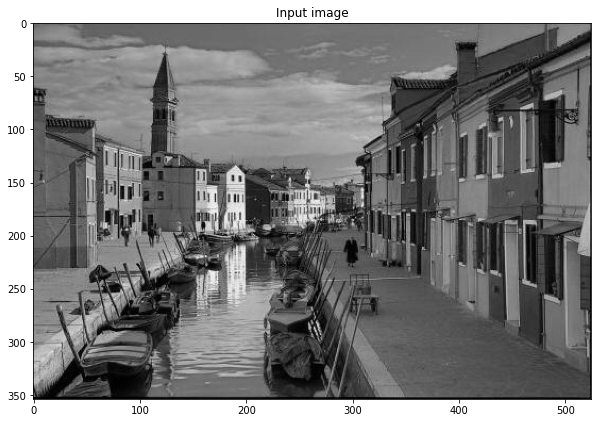

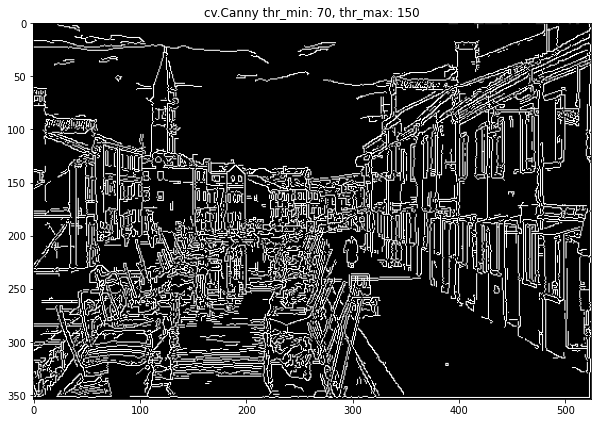

In [24]:
image_nr = 2
thresh_min = 70
thresh_max = 150

img = read_image(image_nr)
fig = plt.figure(figsize=(10, 10))
plt.title('Input image')
plt.imshow(img, cmap='gray')
edges_canny = canny_cv(img, thresh_min, thresh_max)
fig = plt.figure(figsize=(10, 15))
plt.title(f'cv.Canny thr_min: {thresh_min}, thr_max: {thresh_max}')
plt.imshow(edges_canny, cmap='gray')

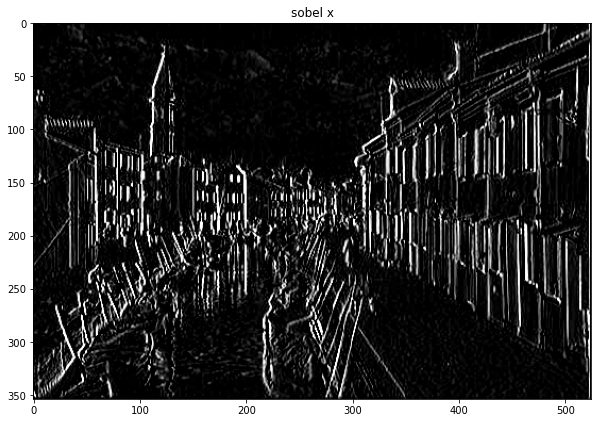

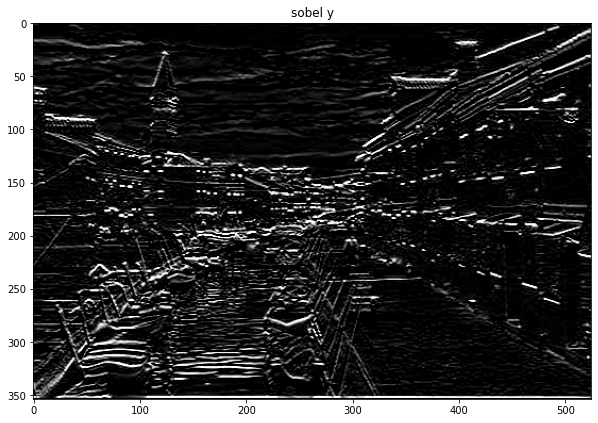

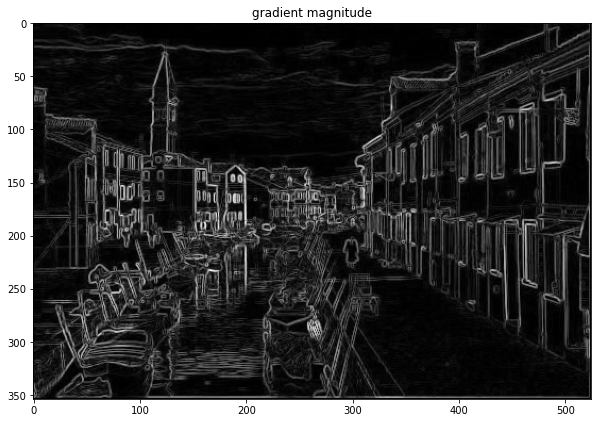

In [27]:
mag, grad_dir, gx, gy = sobel(img, True)

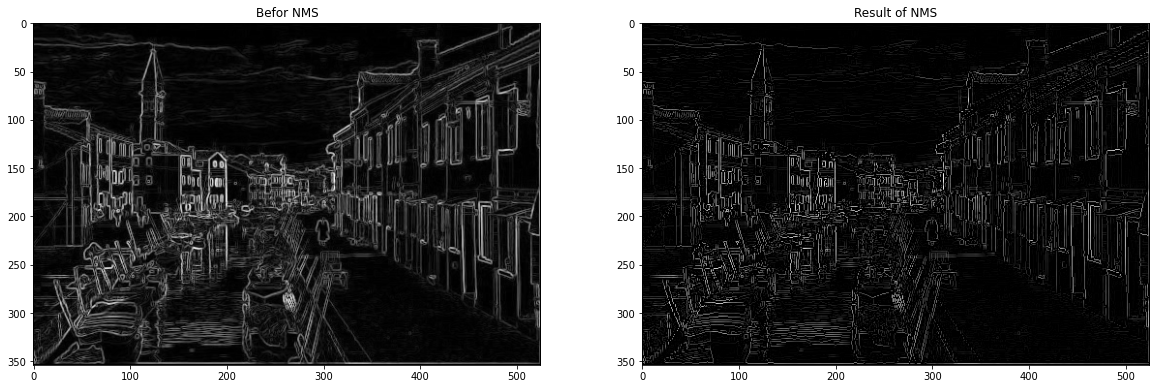

In [5]:

supressed = non_max_suppression(mag, grad_dir, True)

Hysteresis

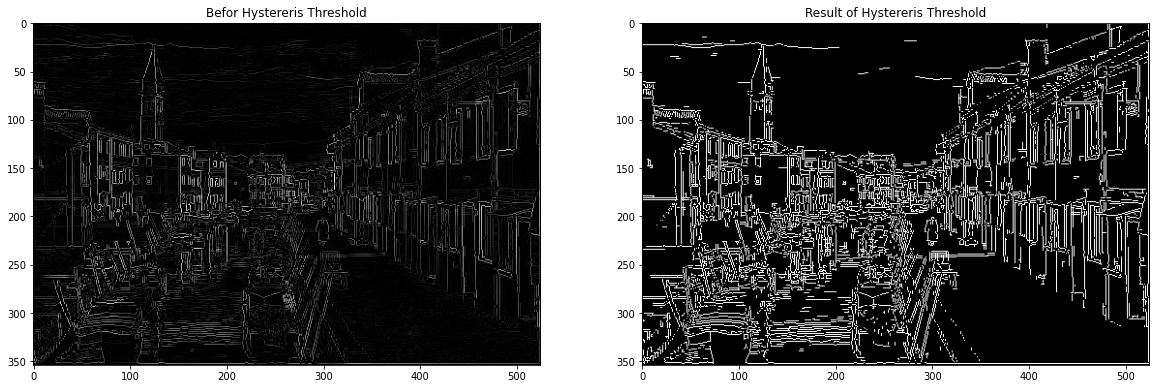

In [10]:
hyst = hysteresis_threshold(supressed, thresh_min, thresh_max, True)

cv.Canny vs. own Sobel implementation

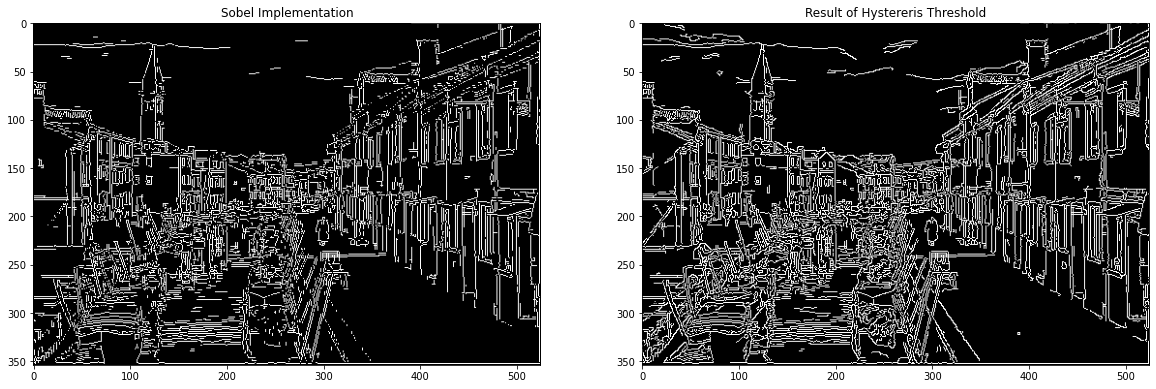

In [12]:
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Sobel Implementation')
ax.imshow(hyst, cmap='gray')
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Result of Hystereris Threshold')
ax.imshow(edges_canny, cmap='gray')

c) Binomial


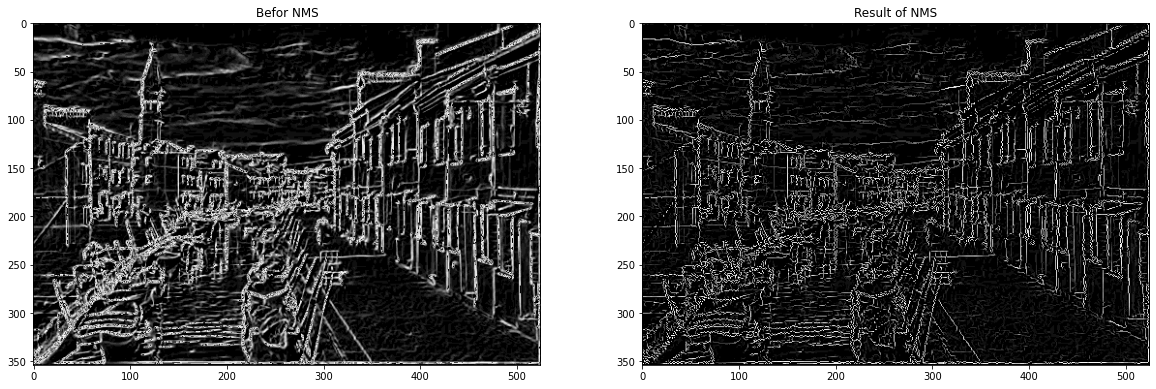

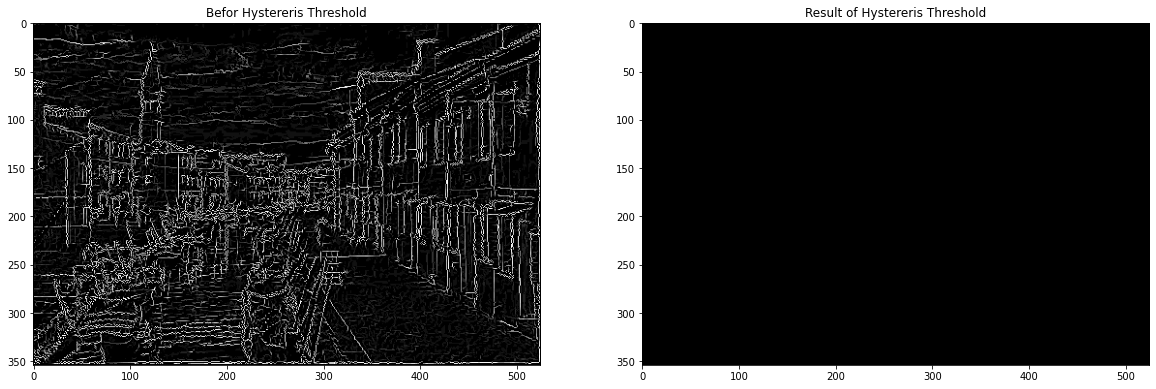

In [50]:
mag, dir = binomial_edge_filter(img, 2)

supressed = non_max_suppression(mag, dir, True)
hyst = hysteresis_threshold(supressed, thresh_min, thresh_max, True)

d) Gaussian

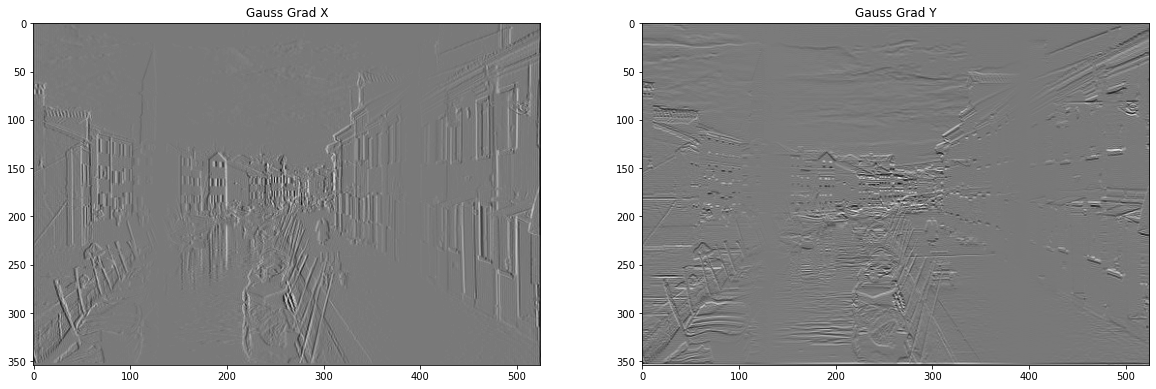

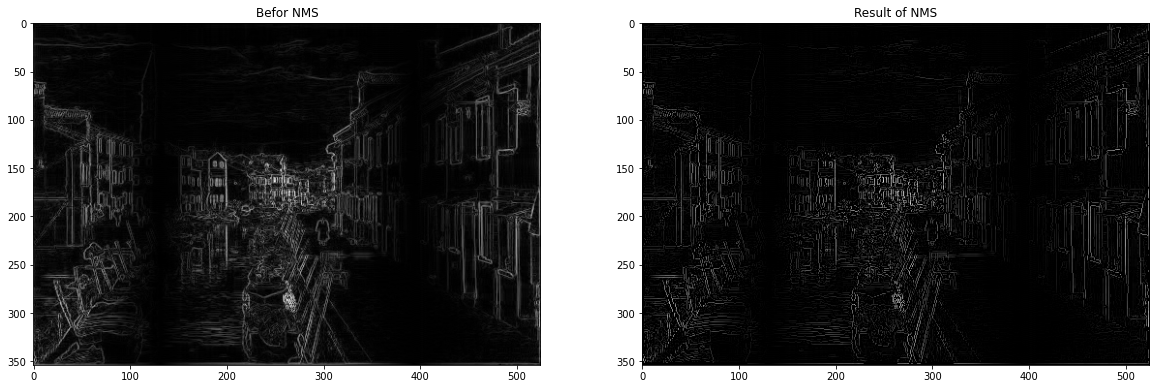

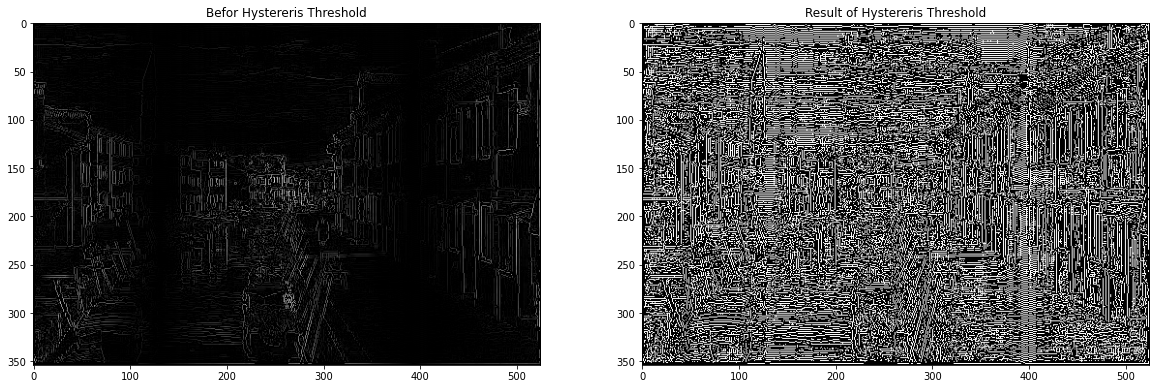

In [52]:
mag, dir = gaussian_edge_filter(img, 0.001, True)

supressed = non_max_suppression(mag, dir, True)
hyst = hysteresis_threshold(supressed, thresh_min, thresh_max, True)